In this notebook, we used transfer learning(Inception_v3) to detect tumors. 

TODO(12.8):
* Write functions to get slide a window across the slide. Extract patches and labels (using the tissue mask).
* Normal and tumor class imbalance problem: sampling. 
* Build pre-trained model. 
* Evaluation and Predictions. 
* Get heatmap at level 7. 

---

ISSUES (12.8):
* How to get predictions for level 7 slide if we trained on level 5? 
* Different tumor slide is not the same size! 
* We do not have normal slide, how to resample accurately?









In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import keras
import urllib
import tensorflow as tf
import gc

Using TensorFlow backend.


## Step 1: Download and Read Slide

In [0]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

In [4]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
('Slide includes %d levels', 8)
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


## Step 2: Extract Patches and Labels

In [0]:
## define window_size, center_size, stride
# zoom_level=5
window_size=299
center_size=128
stride=128

In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

(3360, 3840, 3)


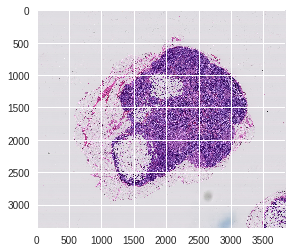

In [7]:
# Example: read the entire slide at level 5

# High zoom levels may not fit into memory.
# That's why we use OpenSlide. You can use the below function
# to extract regions from high zoom levels without having to 
# read the entire image.

# Note: this is just for demo purposes. 

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to see if same region on the mask image contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

zoom_level = 4

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=zoom_level, 
                         width=slide.level_dimensions[zoom_level][0], 
                         height=slide.level_dimensions[zoom_level][1])

# plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
print(slide_image.shape)

(3360, 3840)


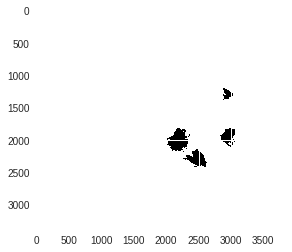

In [8]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=zoom_level, 
                        width=slide.level_dimensions[zoom_level][0], 
                        height=slide.level_dimensions[zoom_level][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]
mask_size = mask_image.shape

# plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)
print(mask_image.shape)

In [0]:
# We'll find non-tissue areas by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

In [0]:
def extract_patches_labels(slide_image,mask_image,zoom_level,x=0,y=0,
                           window_size=299,center_size=128,stride=128):
  
  """This function will generate images from slide
  
  Arguments:
    slide_image, mask_image: images of slide and labels
    zoom_level: the level that we want to look at
    x,y: start coordinates
    window_size: size of the window used to get images from slide
    stride: step
      
  Returns:
    returns sub-images array from slide and their corresponding labels
    
  """
  num_grid= (((slide_image.shape[0]-window_size+1)//stride)+1)*(((slide_image.shape[1]-window_size+1)//stride)+1)
  imgs=np.zeros((num_grid,window_size,window_size,3))
  labels=np.zeros(num_grid)
  half_grid=center_size/2
  count=0
  
  for i in range(0,slide_image.shape[0]-window_size+1,stride):
    for j in range(0,slide_image.shape[1]-window_size+1,stride):
      x_pos=i+center_size
      y_pos=j+center_size
      grid_slide=slide_image[i:(i+window_size),j:(j+window_size),:]
      imgs[count,:,:,:]=grid_slide
      grid_label=mask_image[(x_pos-half_grid):(x_pos+half_grid),(y_pos-half_grid):(y_pos+half_grid)]
#       if np.mean(grid_label) >0.2:
#         labels[count]=1.
#       count += 1
      labels[count] = np.argmax([np.mean(grid_label==0), np.mean(grid_label==1)*128, np.mean(grid_label==2)/2])
      count += 1
    
  return imgs, labels

In [11]:
### assign label 2 for non-tissue areas
tissue_coor_list = find_tissue_pixels(slide_image)
w, h = mask_image.shape
mask_image_triple = np.ones(mask_image.shape) * 2

for (x, y) in tissue_coor_list:
  mask_image_triple[x][y] = mask_image[x][y]
  
del mask_image
gc.collect()

5097

In [0]:
patches, labels = extract_patches_labels(slide_image,mask_image_triple,zoom_level,x=0,y=0,
                                         window_size=window_size,center_size=center_size,stride=stride)

In [13]:
np.unique(labels,return_counts=True)

(array([0., 1., 2.]), array([196,  33, 443]))

In [14]:
del slide_image
gc.collect()

0

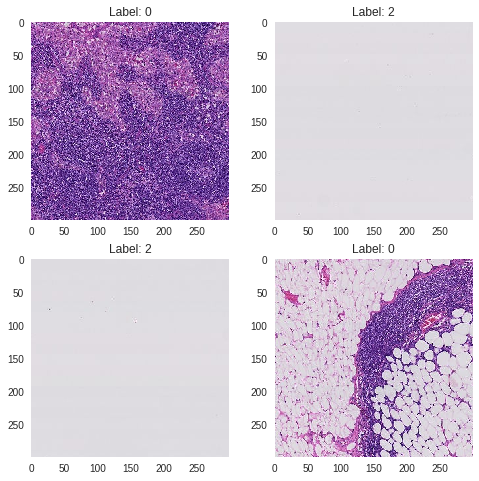

In [15]:
#Show some patches that we've got
plt.figure(figsize=(8,8))
count=1
for i in np.random.choice(len(patches),4):
  plt.subplot(2,2,count)
  plt.imshow(patches[i].astype('uint8'))
  plt.grid(False)
  plt.title('Label: {}'.format(labels[i].astype('uint8')))
  count += 1

Here, we've got 143 patches and their labels in the center region. However, this slide only contains 15 tumor patches. That is to say, the number of patches and the tumor class are extremely unbalanced. In order to avoid biases towards slides
containing more patches (both normal and tumor), we resampled our data. 

## Step 3: Resample Data

In [0]:
## version 3.0
def sample_image_withnoise(img, label, noise = 0, control = True):
  """
  Use sampling(with replacement) to convert unbanlanced data to banlanced data
  input:
    img: np.array, n*width*height*channel
    label: np.array, n*1
    nums: number of samples
  output:
    sample_img: np.array, n*width*height*channel
    sample_label: label: np.array, n*1
  """
  n,w,h,c = img.shape
  sample_img = []
  positive_ind = [index for index, value in enumerate(label) if value == 1]
  negative_ind = [index for index, value in enumerate(label) if value == 0]
  if control:
    nums = 2000
  else:
    nums = n
  sample_label = np.random.choice([0.,1.], nums)
  
  for flag in sample_label:
    if flag:
      ind = np.random.choice(positive_ind,1)[0]
      sample_img.append( img[ind,:,:,:] + np.random.uniform(0,127.5,w*h*c).reshape(w,h,c) * noise  )
    else:
      ind = np.random.choice(negative_ind,1)[0]
      sample_img.append( img[ind,:,:,:] + np.random.uniform(0,127.5,w*h*c).reshape(w,h,c) * noise )
      
#   sample_img = img[ind_list,:]

  del img
  gc.collect()
  sample_img = np.array(sample_img)
  return(sample_img, sample_label)

In [0]:
patches_res,labels_res=sample_image_withnoise(patches, labels, 0, False)  # without noise

In [18]:
del patches
gc.collect()

0

In [19]:
np.unique(labels_res,return_counts=True)

(array([0., 1.]), array([325, 347]))

In [0]:
# patches /=255
# patches_res/=255

## Step 4: Pre-trained Model

### transfer learning 

In [0]:
def build_model(window_size):
  model = tf.keras.applications.InceptionV3(input_shape=(window_size, window_size, 3), 
                                                         include_top=False)
  model.trainable = False
  x = model.output
  x = tf.keras.layers.Flatten()(x)
  #x = tf.keras.layers.Dense(512, activation="relu")(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  predictions = tf.keras.layers.Dense(1, activation="sigmoid")(x)

  # creating the baseline model 
  model_baseline = tf.keras.models.Model(inputs = model.input, outputs = predictions)
  model_baseline.compile(loss = "binary_crossentropy",
                         optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001),
                         metrics=["accuracy"])
  return model_baseline

In [0]:
base_model=build_model(window_size)
# base_model.summary()

In [23]:
epochs=3
batch_size=10

base_model.fit(patches_res/255,labels_res,batch_size=batch_size,epochs=epochs,validation_split=0.2)

Train on 537 samples, validate on 135 samples
Epoch 1/3
537/537 [==============================] - 43s 80ms/step - loss: 2.1874 - acc: 0.6797 - val_loss: 6.8103 - val_acc: 0.5259
Epoch 2/3
537/537 [==============================] - 26s 48ms/step - loss: 1.6209 - acc: 0.8138 - val_loss: 5.5902 - val_acc: 0.5630
Epoch 3/3
537/537 [==============================] - 25s 47ms/step - loss: 0.8194 - acc: 0.8901 - val_loss: 6.7621 - val_acc: 0.5259


### custom model

In [0]:
### layers defination
custom_model = tf.keras.models.Sequential()
custom_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(299, 299, 3),
                 padding='same'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
custom_model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3),
                                    activation='relu',
                                    padding='same'))
custom_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
custom_model.add(tf.keras.layers.Flatten())
custom_model.add(tf.keras.layers.Dense(128, activation='relu'))
custom_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
custom_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
epochs=5
batch_size=10

custom_model.fit(patches_res/255,labels_res,batch_size=batch_size,epochs=epochs,validation_split=0.2)

Train on 537 samples, validate on 135 samples
Epoch 1/5
537/537 [==============================] - 9s 17ms/step - loss: 0.7690 - acc: 0.5717 - val_loss: 0.6212 - val_acc: 0.7704
Epoch 2/5
537/537 [==============================] - 5s 10ms/step - loss: 0.5750 - acc: 0.7412 - val_loss: 0.4920 - val_acc: 0.8000
Epoch 3/5
537/537 [==============================] - 5s 10ms/step - loss: 0.4820 - acc: 0.7784 - val_loss: 0.4633 - val_acc: 0.7778
Epoch 4/5
537/537 [==============================] - 5s 10ms/step - loss: 0.3666 - acc: 0.8622 - val_loss: 0.3207 - val_acc: 0.9333
Epoch 5/5
537/537 [==============================] - 5s 10ms/step - loss: 0.2633 - acc: 0.9348 - val_loss: 0.2896 - val_acc: 0.8593


In [26]:
### clear RAM
del patches_res
gc.collect()

0

## Step 5: Predict and Plot Heatmap for Level 7

In [0]:
#Download a test slide
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# file_list = drive.ListFile(
#     {'q': "'1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5' in parents"}).GetList()

fname = 'tumor_078.tif'
if not os.path.exists(fname): 
  f_ = drive.CreateFile({'id': '1cAFgPCkGR0zH0gqCDo4yBnstNoZmjp3C'})
  f_.GetContentFile(fname)
  fname = 'tumor_078_mask.tif'
  f_ = drive.CreateFile({'id': '1ZC2urznY3gRebUG3PN2BtYD1ZPZ7GPYq'})
  f_.GetContentFile(fname)

In [0]:
# slide_path_test='tumor_078.tif'
# mask_path_test='tumor_078_mask.tif'
slide_path_test='tumor_091.tif'
mask_path_test='tumor_091_mask.tif'
slide_test = open_slide(slide_path_test)
mask_test=open_slide(mask_path_test)

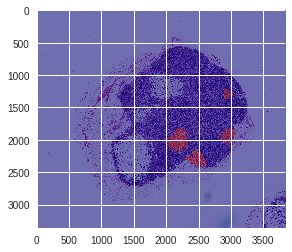

In [29]:
# zoom_level=4
slide_image_test = read_slide(slide_test, x=0, y=0,level=zoom_level, 
                         width=slide_test.level_dimensions[zoom_level][0], 
                         height=slide_test.level_dimensions[zoom_level][1])

mask_image_test = read_slide(mask_test, 
                        x=0, 
                        y=0, 
                        level=zoom_level, 
                        width=slide_test.level_dimensions[zoom_level][0], 
                        height=slide_test.level_dimensions[zoom_level][1])

mask_image_test = mask_image_test[:,:,0]

# plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_test)
plt.imshow(mask_image_test,cmap='jet', alpha=0.5)

In [30]:
mask_image_test.shape

(3360, 3840)

In [0]:
patches_test, labels_test = extract_patches_labels(slide_image_test,mask_image_test,zoom_level,x=0,y=0,
                                                   window_size=window_size,center_size=center_size,stride=stride)

In [0]:
y_pred_test_base = base_model.predict(patches_test)
y_pred_test_custom = custom_model.predict(patches_test)

nums_pred, _ = y_pred_test_base.shape

In [33]:
del patches_test
gc.collect()

29

In [34]:
np.mean(labels_test == np.round(y_pred_test_base))
np.mean(labels_test == np.round(y_pred_test_custom))

0.8542729591836735

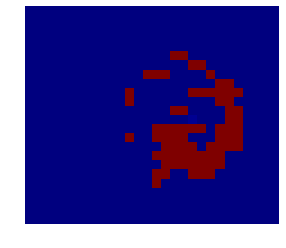

In [35]:
small_width = int(mask_size[0] / np.sqrt(mask_size[0]*mask_size[1] / nums_pred))
# small_height = int(mask_size[1] / np.sqrt(mask_size[0]*mask_size[1] / nums_pred))

plt.imshow(y_pred_test_custom.reshape(small_width,nums_pred / small_width),cmap='jet',vmin=0,vmax=1)
plt.grid(False)
plt.axis('off')
plt.savefig('result.jpg',bbox_inches='tight')

In [0]:
## convert labels to mask
def label2mask(y_pred, mask_size, center_size = 128, window_size = 299, stride = 128, center = True):
  
  if center:
    half_grid=center_size/2
  else:
    half_grid=window_size/2
    
  mask_pred=np.zeros(mask_size)
  
  count=0
  for i in range(0,mask_size[0]-window_size+1,stride):
    for j in range(0,mask_size[1]-window_size+1,stride):
      x_pos=i+center_size
      y_pos=j+center_size

      mask_pred[(x_pos-half_grid):(x_pos+half_grid),(y_pos-half_grid):(y_pos+half_grid)]=y_pred[count]
      
      count += 1
  return(mask_pred)

In [0]:
mask_image_test_base = label2mask(y_pred_test_base, mask_size, center_size = 128,
                                  window_size = 299, stride = 128, center = True)
mask_image_test_custom = label2mask(y_pred_test_custom, mask_size, center_size = 128,
                                    window_size = 299, stride = 128, center = True)

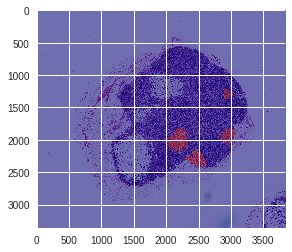

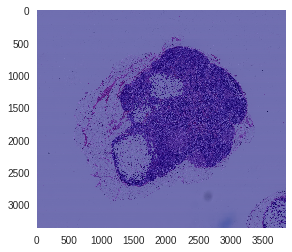

In [42]:
## baseline model plot
plt.imshow(slide_image_test)
plt.imshow(mask_image_test,cmap='jet',alpha=0.5)
plt.show()
plt.imshow(slide_image_test)
plt.imshow(mask_image_test_base,cmap='jet',alpha=0.5)
plt.grid(False)
plt.show()
plt.savefig('result.jpg')

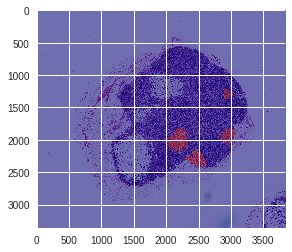

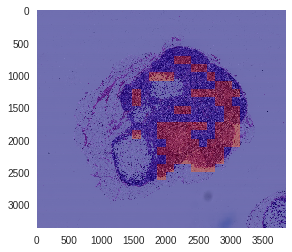

In [43]:
## baseline model plot
plt.imshow(slide_image_test)
plt.imshow(mask_image_test,cmap='jet',alpha=0.5)
plt.show()
plt.imshow(slide_image_test)
plt.imshow(mask_image_test_custom,cmap='jet',alpha=0.5)
plt.grid(False)
plt.show()
plt.savefig('result.jpg')

In [0]:
# mask_pred_resize=np.zeros(mask_image_level7.shape)
# for i in range(0,mask_pred.shape[0]-4+1,4):
#   for j in range(0,mask_pred.shape[1]-4+1,4):
#     mask_pred_resize[i//4,j//4]=np.max(mask_pred[i:(i+4),j:(j+4)])
#     #count += 1

In [41]:
# zoom_level=7
slide_image_level7=read_slide(slide, x=0, y=0, level=zoom_level, 
                              width=slide.level_dimensions[zoom_level][0], 
                              height=slide.level_dimensions[zoom_level][1])
mask_image_level7=read_slide(tumor_mask, x=0, y=0, level=zoom_level, 
                              width=slide.level_dimensions[zoom_level][0], 
                              height=slide.level_dimensions[zoom_level][1])
mask_image_level7=mask_image_level7[:,:,0]
p=mask_pred_resize.copy()
p[mask_pred_resize>0.5]=1
p[mask_pred_resize<0.5]=0


plt.figure(figsize=(5,5))
plt.imshow(slide_image_level7)
#plt.imshow(y_pred.reshape(11,13),cmap='jet',alpha=0.5)
#plt.imshow(mask_pred_resize[:,:,0],cmap='jet',alpha=0.5)
plt.imshow(p,cmap='jet',alpha=0.5)
#plt.imshow(mask_image_level7,cmap='jet',alpha=0.5)
plt.imshow(mask_image_level7,cmap='jet',alpha=0.5)
plt.grid(False)
plt.show()

NameError: ignored

## Step 6: Evaluation